<a href="https://colab.research.google.com/github/bams39/google_colab_tiket_telco_infra/blob/main/%5BBambang%5D_Salinan_dari_TT_Penalty_Prediction_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

excel_file = 'Raw_TT_2024.xlsx'
df = pd.read_excel(excel_file)

display(df.head())

,Log Number,Open Date Time,Closed Date Time,Severity,Case Name,Customers,Region Name,Residence Name,Case_Group,AgingTimeHour,SLA_STATUS_OPERATOR_FINAL,WeekNumber,Year,Month,PotensiPenalty,TypeSite
0,23730267,2024-01-01 00:04:16,2024-01-01 00:23:55,EMERGENCY,Troubleshoot : PLN Off / Listrik Padam,TSEL,SUMBAGUT,NAGAN RAYA,PLN OFF,0.316667,IN_SLA,1,2024,1,0.0,Pasif
1,23730283,2024-01-01 00:25:59,2024-01-01 00:32:17,EMERGENCY,Troubleshoot : PLN Off / Listrik Padam,XL,JATENG,MAGELANG,PLN OFF,0.116667,IN_SLA,1,2024,1,0.0,Pasif
2,23730278,2024-01-01 00:21:02,2024-01-01 00:39:15,EMERGENCY,Troubleshoot : PLN Off / Listrik Padam,SMARTFREN,JABAR,SUMEDANG,PLN OFF,0.300000,IN_SLA,1,2024,1,0.0,Pasif
3,23730297,2024-01-01 00:40:22,2024-01-01 00:46:51,EMERGENCY,Troubleshoot : PLN Off / Listrik Padam,SMARTFREN,JATENG,WONOSOBO,PLN OFF,0.100000,IN_SLA,1,2024,1,0.0,Pasif
4,23730282,2024-01-01 00:24:31,2024-01-01 00:56:49,EMERGENCY,Community Issue : Sewa Lahan ( BTS Off ),XL,JABAR,SUBANG,Community Issue,0.533333,IN_SLA,1,2024,1,0.0,Pasif


Logistic Regression

In [ ]:
# =========================
# 0) IMPORTS
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, auc, precision_score, recall_score, f1_score
)

# =========================
# 1) LABEL & DATETIME
# =========================
df = df.copy()

# Label biner: ada penalty > 0 → 1, else 0
df['IsPenalty'] = (df['PotensiPenalty'].fillna(0) > 0).astype(int)

# Pastikan datetime
for c in ['Open Date Time','Closed Date Time']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# =========================
# 2) LEAD TIME (jam) + TREATMENT OUTLIER
# =========================
if 'AgingTimeHour' in df.columns and pd.to_numeric(df['AgingTimeHour'], errors='coerce').notna().sum() > 0:
    df['LeadTimeHours'] = pd.to_numeric(df['AgingTimeHour'], errors='coerce')
else:
    df['LeadTimeHours'] = (df['Closed Date Time'] - df['Open Date Time']).dt.total_seconds()/3600

# buang baris tanpa lead time
df = df[df['LeadTimeHours'].notna()].copy()

# cap outlier (lebih aman daripada drop)
hi = df['LeadTimeHours'].quantile(0.99)
df.loc[df['LeadTimeHours'] < 0, 'LeadTimeHours'] = 0
df.loc[df['LeadTimeHours'] > hi, 'LeadTimeHours'] = hi

# =========================
# 3) TIME FEATURES
# =========================
df['HourOpen']  = df['Open Date Time'].dt.hour
df['DayOfWeek'] = df['Open Date Time'].dt.day_name()
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday','Sunday']).astype(int)

if 'WeekNumber' not in df.columns and 'Open Date Time' in df.columns:
    df['WeekNumber'] = df['Open Date Time'].dt.isocalendar().week.astype(int)

if 'Month_Open' not in df.columns and 'Open Date Time' in df.columns:
    df['Month_Open'] = df['Open Date Time'].dt.month

# =========================
# 4) SEVERITY NUMERIC + SLA FEATURES (opsional tapi disarankan)
# =========================
sev_map = {'MINOR':1,'LOW':1,'MAJOR':2,'MEDIUM':2,'CRITICAL':3,'HIGH':3}
if 'Severity' in df.columns:
    df['Severity_norm'] = df['Severity'].astype(str).str.upper().map(sev_map)

# SLA per customer (contoh; sesuaikan jika beda)
sla_map = {'TSEL': 4, 'XL': 6, 'ISAT': 8, 'H3I': 6, 'SMARTFREN': 8}
if 'Customers' in df.columns:
    df['SLA_Target_Hour'] = df['Customers'].map(sla_map)
    df['SLA_Diff'] = df['LeadTimeHours'] - df['SLA_Target_Hour']

# =========================
# 5) PILIH FITUR
# =========================
feature_cols = [
    'Severity_norm','Case Name','Customers','Region Name','Residence Name','Vendor Name',
    'Case_Group','SLA_STATUS_OPERATOR_FINAL','TypeSite',
    'LeadTimeHours','WeekNumber','Month_Open','HourOpen','DayOfWeek','IsWeekend',
    'SLA_Target_Hour','SLA_Diff'
]
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].copy()
y = df['IsPenalty'].astype(int)

# =========================
# 6) PREPROCESSOR (SPARSE-FRIENDLY)
# =========================
# tentukan kolom numerik vs kategori (update Case_Group)
num_cols = [c for c in ['Severity_norm','LeadTimeHours','WeekNumber','Month_Open','HourOpen','IsWeekend','SLA_Target_Hour','SLA_Diff'] if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='most_frequent')),       # isi missing dulu
            ('to_str', FunctionTransformer(lambda X: X.astype(str))),# SERAGAMKAN → string
            ('ohe', OneHotEncoder(handle_unknown='ignore', dtype=np.float32))
        ]), cat_cols),
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median'))
        ]), num_cols),
    ],
    remainder='drop'
)

# =========================
# 7) SPLIT: TRAIN / VALIDATION / TEST
# =========================
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_tr2, X_val, y_tr2, y_val = train_test_split(X_tr, y_tr, test_size=0.20, stratify=y_tr, random_state=42)

# =========================
# 8) MODEL: LOGISTIC REGRESSION (IMBALANCE-AWARE)
# =========================
logit = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',   # penting utk imbalance
    solver='saga',             # cocok utk data besar & sparse
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline(steps=[('prep', preprocess), ('mdl', logit)])

# Train
pipe.fit(X_tr2, y_tr2)

# =========================
# 9) TUNING THRESHOLD BERDASARKAN TARGET RECALL (PAKAI VALIDATION)
# =========================
proba_val = pipe.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)
pr_auc_val = auc(rec, prec)

target_recall = 0.80

# pilih threshold dengan recall >= target dan precision tertinggi
mask = rec[:-1] >= target_recall
if mask.any():
    idx = np.argmax(prec[:-1][mask])
    best_th = thr[mask][idx]
else:
    # fallback: ambil recall terdekat
    idx = np.argmin(np.abs(rec[:-1] - target_recall))
    best_th = thr[idx]

print(f"[VALIDATION] PR-AUC={pr_auc_val:.3f} | Best threshold @target recall {target_recall:.2f}: {best_th:.4f}")
print(f"[VALIDATION] Recall={rec[:-1][mask][idx]:.3f} | Precision={prec[:-1][mask][idx]:.3f}" if mask.any() else
      f"[VALIDATION] Recall≈{rec[:-1][idx]:.3f} | Precision≈{prec[:-1][idx]:.3f}")

# =========================
# 10) EVALUASI DI TEST (FINAL)
# =========================
proba_te = pipe.predict_proba(X_te)[:, 1]
y_pred_05 = (proba_te >= 0.5).astype(int)
y_pred_tuned = (proba_te >= best_th).astype(int)

print("\n=== Baseline @0.5 ===")
print(classification_report(y_te, y_pred_05, digits=3))
print("Confusion matrix @0.5:\n", confusion_matrix(y_te, y_pred_05))

print(f"\n=== Tuned @threshold={best_th:.4f} (target recall {target_recall:.2f}) ===")
print(classification_report(y_te, y_pred_tuned, digits=3))
print("Confusion matrix (tuned):\n", confusion_matrix(y_te, y_pred_tuned))

# PR-AUC di TEST
prec_te, rec_te, _ = precision_recall_curve(y_te, proba_te)
print(f"\n[TEST] PR-AUC: {auc(rec_te, prec_te):.3f}")

# =========================
# 11) TABEL THRESHOLD vs PRECISION/RECALL (opsional, untuk presentasi)
# =========================
pr_table = pd.DataFrame({
    'threshold': thr,
    'recall': rec[:-1],
    'precision': prec[:-1]
})
# contoh: tampilkan 10 baris terdekat recall target
pr_table['gap'] = (pr_table['recall'] - target_recall).abs()
print("\nThreshold table (top 10 dekat target recall):")
print(pr_table.sort_values('gap').head(10)[['threshold','recall','precision']])

# =========================
# 12) METRIK PER CUSTOMER (di TEST)
# =========================
# satukan prediksi ke frame test untuk analisis per customer
X_te_with_labels = X_te.copy()
X_te_with_labels['Actual'] = y_te.values
X_te_with_labels['Pred']   = y_pred_tuned

metrics = []
if 'Customers' in X_te_with_labels.columns:
    for cust, g in X_te_with_labels.groupby('Customers'):
        y_true = g['Actual']
        y_hat  = g['Pred']
        metrics.append({
            'Customer': cust,
            'Total_TT': len(g),
            'Penalty_TT': int(y_true.sum()),
            'Recall': recall_score(y_true, y_hat, zero_division=0),
            'Precision': precision_score(y_true, y_hat, zero_division=0),
            'F1': f1_score(y_true, y_hat, zero_division=0),
        })
    perf_per_cust = pd.DataFrame(metrics).sort_values('Recall', ascending=False)
    print("\n=== Performance per Customer (TEST) ===")
    print(perf_per_cust.to_string(index=False))
else:
    print("\nKolom 'Customers' tidak ditemukan pada X_test; skip per-customer metrics.")

# =========================
# 13) CATATAN:
# - Model ini menghasilkan probabilitas yang "smooth" (tidak hanya 0/1) karena:
#   * Logistic Regression + class_weight balanced
#   * OneHot (sparse) + StandardScaler(with_mean=False)
# - Threshold dipilih di VALIDATION, lalu dievaluasi di TEST (lebih fair).
# - Jika ingin menaikkan recall lagi, turunkan threshold best_th sedikit; trade-off: precision turun.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[VALIDATION] PR-AUC=0.983 | Best threshold @target recall 0.80: 1.0000
[VALIDATION] Recall=1.000 | Precision=0.975

=== Baseline @0.5 ===
              precision    recall  f1-score   support

           0      1.000     0.999     1.000     72650
           1      0.923     1.000     0.960       578

    accuracy                          0.999     73228
   macro avg      0.962     1.000     0.980     73228
weighted avg      0.999     0.999     0.999     73228

Confusion matrix @0.5:
 [[72602    48]
 [    0   578]]

=== Tuned @threshold=1.0000 (target recall 0.80) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     72650
           1      0.973     1.000     0.986       578

    accuracy                          1.000     73228
   macro avg      0.987     1.000     0.993     73228
weighted avg      1.000     1.000     1.000     73228

Confusion matrix (tuned):
 [[72634    16]
 [    0   578]]

[TEST] PR-AUC: 0.982

Threshold table (t


=== Top 25 Most Influential Encoded Features (by |coef|) ===
                                            feature_out       coef  abs_coef
                  cat__SLA_STATUS_OPERATOR_FINAL_IN_SLA -35.529344 35.529344
                 cat__SLA_STATUS_OPERATOR_FINAL_OUT_SLA  31.289767 31.289767
                                        cat__TypeSite_0 -28.108974 28.108974
                                    cat__TypeSite_Pasif  23.869397 23.869397
                                    cat__Customers_TSEL  -8.353743  8.353743
                               cat__Customers_SMARTFREN   7.998488  7.998488
                                     num__Severity_norm   5.141317  5.141317
    cat__Case Name_Troubleshoot : Lampu Putus (Halaman)  -4.694852  4.694852
cat__Case Name_Community Issue : Sewa Lahan ( BTS Off )  -4.665656  4.665656
                                    cat__Customers_ISAT  -4.319602  4.319602
    cat__Case Name_Troubleshoot : Kotor / Rumput Tinggi  -4.184953  4.184953
              

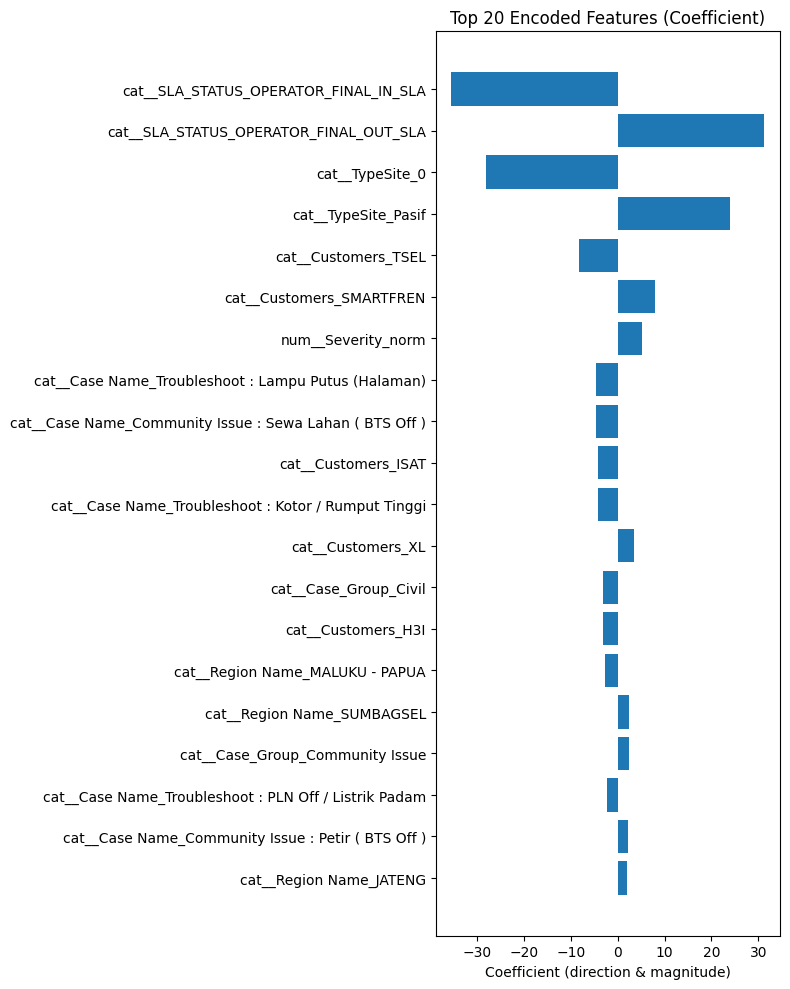

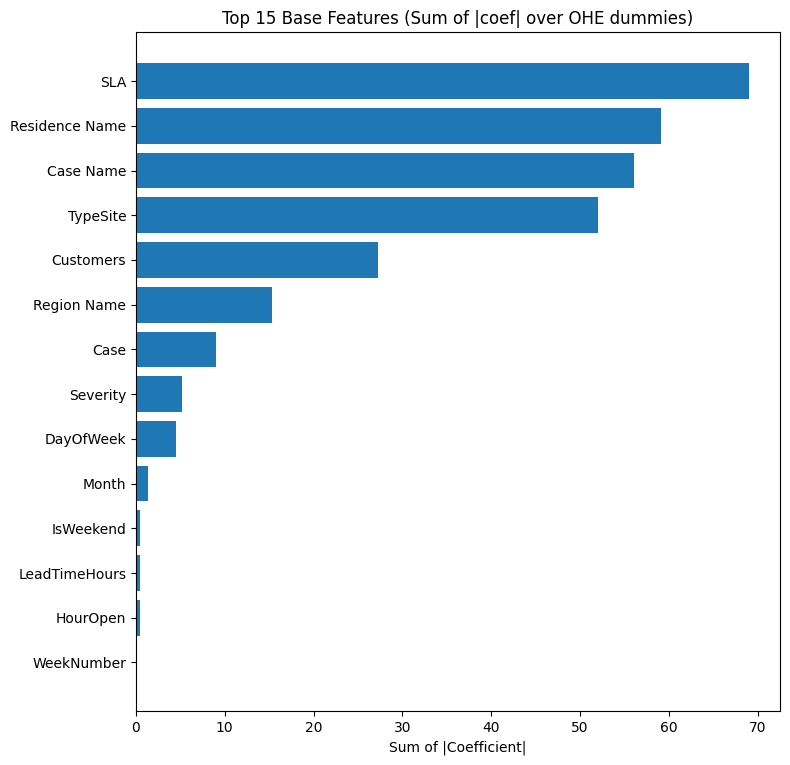


Saved: feature_importance_encoded_logit.csv & feature_importance_base_logit.csv


In [ ]:
# =========================
# 14) FEATURE NAMES & GLOBAL IMPORTANCE (LOGISTIC REGRESSION)
# =========================
import re
import matplotlib.pyplot as plt

prep = pipe.named_steps['prep']
mdl  = pipe.named_steps['mdl']  # LogisticRegression

def get_feature_names_from_ct(ct):
    """
    Ambil nama fitur keluaran ColumnTransformer (robust untuk Pipeline + OHE).
    """
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder':
            # skip drop
            continue

        # Jika trans adalah Pipeline, ambil estimator terakhir
        last = trans
        if hasattr(trans, 'named_steps'):
            # coba ambil step yang punya get_feature_names_out (biasanya OHE)
            for step_name, step_est in trans.named_steps.items():
                if hasattr(step_est, 'get_feature_names_out'):
                    last = step_est
            # jika tidak ada, tetap pakai estimator terakhir
            last = list(trans.named_steps.values())[-1]

        # 1) Estimator punya get_feature_names_out
        if hasattr(last, 'get_feature_names_out'):
            try:
                fn = last.get_feature_names_out(cols)
            except:
                # fallback: tanpa argumen
                fn = last.get_feature_names_out()
        else:
            # 2) Passthrough / SimpleImputer dlsb: pakai nama kolom asli
            fn = np.array(cols, dtype=object)

        # tambahkan prefix transformer agar unik (opsional)
        # sklearn sering menambah 'cat__' / 'num__'
        if isinstance(fn, np.ndarray):
            fn = [f"{name}__{f}" for f in fn]
        else:
            fn = [f"{name}__{fn}"]

        names.extend(fn)
    return np.array(names, dtype=object)

feature_names = get_feature_names_from_ct(prep)

# Koefisien model (binary: shape = [1, n_features])
coef = mdl.coef_.ravel()
assert len(coef) == len(feature_names), "Mismatch feature length vs coefficients."

importance_df = (
    pd.DataFrame({
        'feature_out': feature_names,
        'coef': coef,
        'abs_coef': np.abs(coef)
    })
    .sort_values('abs_coef', ascending=False)
    .reset_index(drop=True)
)

print("\n=== Top 25 Most Influential Encoded Features (by |coef|) ===")
print(importance_df.head(25).to_string(index=False))

# =========================
# 15) AGREGASI KE FITUR ASAL (GABUNG DUMMY OHE)
# =========================
def strip_prefix(s):
    # buang prefix 'cat__' atau 'num__' kalau ada
    return re.sub(r'^(cat|num)__(.*)$', r'\2', s)

def base_source(colname):
    """
    Ambil 'fitur asal' dari nama OHE: 'Case_Group_<kategori>' -> 'Case_Group'
    Untuk numerik, akan tetap nama aslinya.
    """
    s = strip_prefix(colname)
    # OneHotEncoder default: "<kolom>_<kategori>"
    # split sekali di '_' agar kategori yang punya '_' tidak memecah lebih dari sekali
    if '_' in s:
        return s.split('_', 1)[0]
    return s

importance_df['base_feature'] = importance_df['feature_out'].map(base_source)

agg_importance = (
    importance_df
    .groupby('base_feature', as_index=False)['abs_coef']
    .sum()
    .sort_values('abs_coef', ascending=False)
    .reset_index(drop=True)
)

print("\n=== Top 20 Base Features (OHE-aggregated |coef| sum) ===")
print(agg_importance.head(20).to_string(index=False))

# =========================
# 16) VISUALISASI & EXPORT (opsional)
# =========================
# A) Plot Top N encoded features
TOP_N = 20
top_enc = importance_df.head(TOP_N).iloc[::-1]  # balik biar barh naik
plt.figure(figsize=(8, 0.45*TOP_N + 1))
plt.barh(top_enc['feature_out'], top_enc['coef'])
plt.title(f"Top {TOP_N} Encoded Features (Coefficient)")
plt.xlabel("Coefficient (direction & magnitude)")
plt.tight_layout()
plt.show()

# B) Plot Top N base features (agregasi OHE)
TOP_BASE = 15
top_base = agg_importance.head(TOP_BASE).iloc[::-1]
plt.figure(figsize=(8, 0.45*TOP_BASE + 1))
plt.barh(top_base['base_feature'], top_base['abs_coef'])
plt.title(f"Top {TOP_BASE} Base Features (Sum of |coef| over OHE dummies)")
plt.xlabel("Sum of |Coefficient|")
plt.tight_layout()
plt.show()

# C) Export CSV (kalau perlu)
importance_df.to_csv("feature_importance_encoded_logit.csv", index=False)
agg_importance.to_csv("feature_importance_base_logit.csv", index=False)

print("\nSaved: feature_importance_encoded_logit.csv & feature_importance_base_logit.csv")

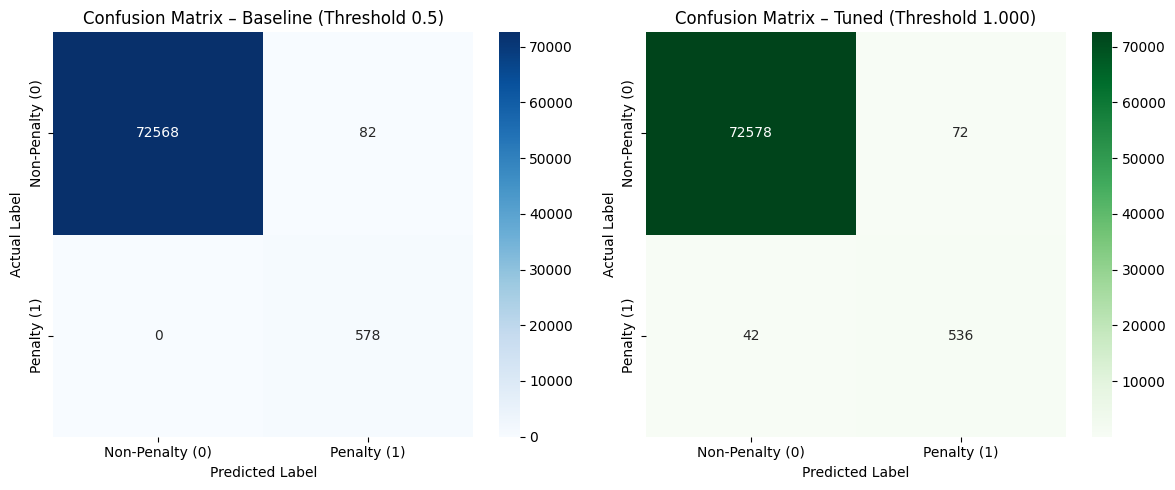

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Hitung prediksi di test ===
y_proba_test = pipe.predict_proba(X_te)[:, 1]

# Baseline threshold 0.5
y_pred_05 = (y_proba_test >= 0.5).astype(int)

# Tuned threshold hasil sebelumnya (misalnya best_th dari validasi)
y_pred_tuned = (y_proba_test >= best_th).astype(int)

# === Confusion matrices ===
cm_05 = confusion_matrix(y_te, y_pred_05)
cm_tuned = confusion_matrix(y_te, y_pred_tuned)

# === Plot side by side ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
sns.heatmap(cm_05, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix – Baseline (Threshold 0.5)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")
axes[0].set_xticklabels(['Non-Penalty (0)', 'Penalty (1)'])
axes[0].set_yticklabels(['Non-Penalty (0)', 'Penalty (1)'])

# Tuned
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title(f"Confusion Matrix – Tuned (Threshold {best_th:.3f})")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")
axes[1].set_xticklabels(['Non-Penalty (0)', 'Penalty (1)'])
axes[1].set_yticklabels(['Non-Penalty (0)', 'Penalty (1)'])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# 1) Ringkas metrik global
report_05 = classification_report(y_te, y_pred_05, output_dict=True, zero_division=0)
report_tuned = classification_report(y_te, y_pred_tuned, output_dict=True, zero_division=0)
cm_05 = confusion_matrix(y_te, y_pred_05)
cm_tuned = confusion_matrix(y_te, y_pred_tuned)

prec_te, rec_te, _ = precision_recall_curve(y_te, proba_te)
pr_auc_test = auc(rec_te, prec_te)

summary_df = pd.DataFrame({
    'Metric': ['PR-AUC (TEST)', 'Best Threshold (val)', 'Target Recall (val)'],
    'Value': [pr_auc_test, best_th, 0.80]
})

# 2) Classification report → DataFrame
def report_to_df(rep_dict):
    df_rep = pd.DataFrame(rep_dict).T
    df_rep.index.name = 'label_or_avg'
    return df_rep.reset_index()

cr_05_df = report_to_df(report_05)
cr_tuned_df = report_to_df(report_tuned)

# 3) Confusion matrix → DataFrame
cm05_df = pd.DataFrame(cm_05, columns=['Pred_0','Pred_1'])
cm05_df.insert(0, 'Actual', ['Actual_0','Actual_1'])

cmt_df = pd.DataFrame(cm_tuned, columns=['Pred_0','Pred_1'])
cmt_df.insert(0, 'Actual', ['Actual_0','Actual_1'])

# 4) Threshold table (ambil 100 baris terdekat target recall biar ringkas)
thr_tbl_export = pr_table.sort_values('gap').head(100).drop(columns=['gap'], errors='ignore')

# 5) Siapkan dataframe prediksi per tiket (TEST SET)
# Ambil kolom identitas dari df asal, kalau ada
id_cols = [c for c in [
    'Log Number','LogNo','Case Name','Case_Group_New','CaseGroup','Customers',
    'Region Name','Residence Name','Vendor Name','Severity',
    'Open Date Time','Closed Date Time'
] if c in df.columns]


# Ambil subset sesuai index test
base_ids = df.loc[X_te.index, id_cols].copy() if len(id_cols)>0 else pd.DataFrame(index=X_te.index)

pred_test_df = base_ids.copy()
pred_test_df['Actual_IsPenalty'] = y_te.values
pred_test_df['Prob_Penalty'] = proba_te
pred_test_df['Pred_05'] = y_pred_05
pred_test_df['Pred_Tuned'] = y_pred_tuned

# (opsional) urutkan dari risiko tertinggi
pred_test_df = pred_test_df.sort_values('Prob_Penalty', ascending=False)

# 6) Tulis ke Excel (multi-sheet)
out_path = 'penalty_model_evaluation.xlsx'
with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    summary_df.to_excel(writer, index=False, sheet_name='Summary')
    cr_05_df.to_excel(writer, index=False, sheet_name='Report@0.5')
    cr_tuned_df.to_excel(writer, index=False, sheet_name='Report@Tuned')
    cm05_df.to_excel(writer, index=False, sheet_name='ConfMat@0.5')
    cmt_df.to_excel(writer, index=False, sheet_name='ConfMat@Tuned')

    # Threshold table & per customer
    thr_tbl_export.to_excel(writer, index=False, sheet_name='Threshold_Table')
    if 'perf_per_cust' in globals():
        perf_per_cust.to_excel(writer, index=False, sheet_name='Per_Customer')

    # Prediksi per tiket
    pred_test_df.to_excel(writer, index=False, sheet_name='Predictions_Test')

print(f"✅ Selesai. File diexport ke: {out_path}")

✅ Selesai. File diexport ke: penalty_model_evaluation.xlsx


=== Summary probability per Case Group (top 20 by volume) ===
                     n  mean_prob           p50           p75           p90  \
CaseGroup                                                                     
PLN OFF          68974   0.003157  5.238437e-14  9.187428e-12  3.445424e-10   
Theft             1604   0.055000  2.936944e-12  2.151753e-08  3.149624e-04   
Spare Part        1386   0.037964  1.159180e-13  3.736260e-10  5.713468e-07   
Civil              573   0.053588  2.582027e-13  3.038593e-10  6.423292e-07   
Community Issue    565   0.410095  4.265850e-06  1.000000e+00  1.000000e+00   
ME                 126   0.072283  6.210392e-14  2.823222e-09  3.380288e-05   

                 max_prob  
CaseGroup                  
PLN OFF               1.0  
Theft                 1.0  
Spare Part            1.0  
Civil                 1.0  
Community Issue       1.0  
ME                    1.0  


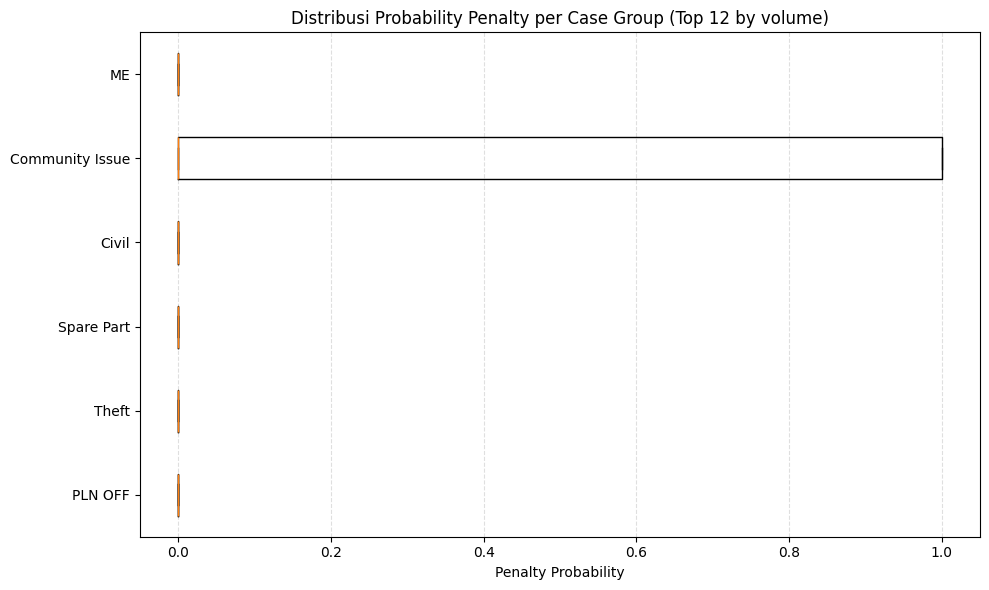

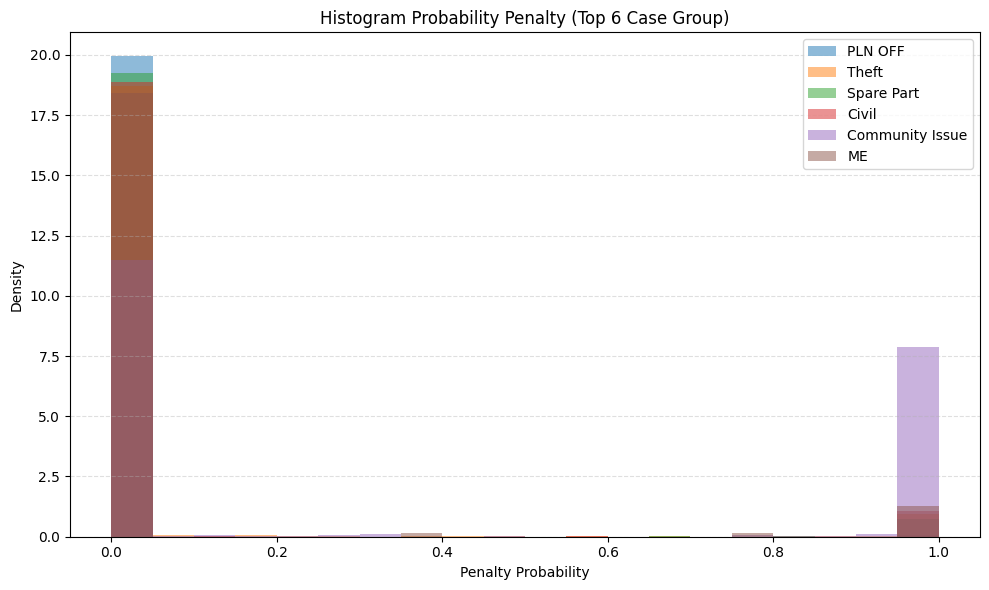

✅ Summary diexport ke probability_by_casegroup_summary.xlsx


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pastikan ada probabilitas penalty untuk TEST SET
try:
    proba_te
except NameError:
    proba_te = pipe.predict_proba(X_te)[:, 1]

# 2) Tentukan kolom Case Group yang tersedia
possible_cols = ['Case_Group', 'CaseGroup', 'Case Group', 'Case Name']
group_col = None
for c in possible_cols:
    if c in X_te.columns:
        group_col = c
        break
if group_col is None:
    raise ValueError("Kolom case group tidak ditemukan. Cek nama kolom seperti 'Case_Group_New' atau 'CaseGroup'.")

# 3) Dataframe probabilitas per tiket + case group
prob_df = pd.DataFrame({
    'CaseGroup': X_te[group_col].astype(str).fillna('UNKNOWN'),
    'ProbPenalty': proba_te
})

# 4) Ringkasan statistik per Case Group
summary = (
    prob_df
      .groupby('CaseGroup')
      .agg(
          n=('ProbPenalty', 'size'),
          mean_prob=('ProbPenalty', 'mean'),
          p50=('ProbPenalty', lambda x: np.percentile(x, 50)),
          p75=('ProbPenalty', lambda x: np.percentile(x, 75)),
          p90=('ProbPenalty', lambda x: np.percentile(x, 90)),
          max_prob=('ProbPenalty', 'max')
      )
      .sort_values(['n','mean_prob'], ascending=[False, False])
)

print("=== Summary probability per Case Group (top 20 by volume) ===")
print(summary.head(20))

# 5) PILIH top-N case group untuk diplot agar tidak penuh
TOP_N = 12
top_groups = summary.head(TOP_N).index.tolist()
plot_df = prob_df[prob_df['CaseGroup'].isin(top_groups)].copy()

# 6) BOX PLOT horizontal per Case Group (distribusi cepat & jelas)
plt.figure(figsize=(10, 6))
data_to_plot = [plot_df.loc[plot_df['CaseGroup']==g, 'ProbPenalty'].values for g in top_groups]
plt.boxplot(data_to_plot, vert=False, showfliers=False)  # showfliers=False biar tidak "ramai"
plt.yticks(ticks=range(1, len(top_groups)+1), labels=top_groups)
plt.xlabel('Penalty Probability')
plt.title(f'Distribusi Probability Penalty per Case Group (Top {TOP_N} by volume)')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 7) (Opsional) HISTOGRAM bertumpuk per grup (lebih detail, tapi besar)
#    Batasi jadi top 6 saja agar terbaca
TOP_HIST = 6
hist_groups = summary.head(TOP_HIST).index.tolist()
bins = np.linspace(0, 1, 21)

plt.figure(figsize=(10, 6))
for g in hist_groups:
    vals = prob_df.loc[prob_df['CaseGroup']==g, 'ProbPenalty'].values
    plt.hist(vals, bins=bins, alpha=0.5, label=g, density=True, histtype='stepfilled')

plt.xlabel('Penalty Probability')
plt.ylabel('Density')
plt.title(f'Histogram Probability Penalty (Top {TOP_HIST} Case Group)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 8) (Opsional) Export summary ke Excel
summary.to_excel('probability_by_casegroup_summary.xlsx', index=True)
print("✅ Summary diexport ke probability_by_casegroup_summary.xlsx")

XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from xgboost import XGBClassifier

df = df.copy()

# === Label biner
df['IsPenalty'] = (df['PotensiPenalty'].fillna(0) > 0).astype(int)

# === Datetime
for c in ['Open Date Time','Closed Date Time']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# === LeadTimeHours
if 'AgingTimeHour' in df.columns and pd.to_numeric(df['AgingTimeHour'], errors='coerce').notna().sum() > 0:
    df['LeadTimeHours'] = pd.to_numeric(df['AgingTimeHour'], errors='coerce')
else:
    df['LeadTimeHours'] = (df['Closed Date Time'] - df['Open Date Time']).dt.total_seconds()/3600

# Buang baris tanpa Open/Closed yang membuat LeadTimeHours NaN
df = df[df['LeadTimeHours'].notna()]

# Cap outlier pakai persentil (lebih aman dari hard 72 jam)
hi = df['LeadTimeHours'].quantile(0.99)
df.loc[df['LeadTimeHours'] < 0, 'LeadTimeHours'] = 0
df.loc[df['LeadTimeHours'] > hi, 'LeadTimeHours'] = hi

sla_map = {'TSEL': 4, 'XL': 6, 'ISAT': 8, 'H3I': 6, 'SMARTFREN': 8}  # jam SLA
df['SLA_Target_Hour'] = df['Customers'].map(sla_map)
df['SLA_Diff'] = df['LeadTimeHours'] - df['SLA_Target_Hour']

# === Feature waktu
df['HourOpen']  = df['Open Date Time'].dt.hour
df['DayOfWeek'] = df['Open Date Time'].dt.day_name()
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday','Sunday']).astype(int)
if 'WeekNumber' not in df.columns and 'Open Date Time' in df.columns:
    df['WeekNumber'] = df['Open Date Time'].dt.isocalendar().week.astype(int)
if 'Month_Open' not in df.columns and 'Open Date Time' in df.columns:
    df['Month_Open'] = df['Open Date Time'].dt.month

# === Severity numerik
sev_map = {'MINOR':1,'LOW':1,'MAJOR':2,'MEDIUM':2,'CRITICAL':3,'HIGH':3}
df['Severity_norm'] = df['Severity'].astype(str).str.upper().map(sev_map)

# === Pilih fitur
feature_cols = [
    'Severity_norm','Case Name','Customers','Region Name','Residence Name','Vendor Name',
    'Case_Group_New','SLA_STATUS_OPERATOR_FINAL','TypeSite',
    'LeadTimeHours','WeekNumber','Month_Open','HourOpen','DayOfWeek','IsWeekend'
]
feature_cols = [c for c in feature_cols if c in df.columns]
X = df[feature_cols].copy()
y = df['IsPenalty'].astype(int)

# === Pisahkan numerik vs kategori
num_cols = ['Severity_norm','LeadTimeHours','WeekNumber','HourOpen','IsWeekend']
num_cols = [c for c in num_cols if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]

# Convert categorical columns to string type to avoid TypeError
for col in cat_cols:
    X[col] = X[col].astype(str)


# === Preprocessor: imputer + encoder (dense)
preprocess = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32))
        ]), cat_cols),
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median'))
        ]), num_cols),
    ],
    remainder='drop'
)

# === Split aman: only stratify if both classes exist
can_stratify = y.nunique() == 2 and y.min()==0 and y.max()==1 and y.sum()>0 and (len(y)-y.sum())>0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y if can_stratify else None,
    random_state=42
)

# If train empty (very rare), shrink test_size
if len(X_train) == 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1,
        stratify=y if can_stratify else None,
        random_state=42
    )

# === scale_pos_weight aman (avoid div by zero)
pos = max(1, int((y_train==1).sum()))
neg = max(1, int((y_train==0).sum()))
scale_pos_weight = np.sqrt(neg / pos)

# === Model
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('mdl',  XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic',  # sudah default, tapi pastikan ada
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

pipe.fit(X_train, y_train)

# === Evaluasi baseline
from sklearn.metrics import classification_report, confusion_matrix
y_pred = pipe.predict(X_test)
print("=== Baseline @0.5 ===")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# === Tuning threshold focus recall
y_proba = pipe.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)

target_recall = 0.90
# Find the index where recall is closest to the target_recall
idx = np.argmin(np.abs(rec - target_recall))
# Use this index to find the corresponding threshold
best_th = thr[idx]

y_pred_adj = (y_proba >= best_th).astype(int)
print(f"\n=== Tuned ===\nthreshold={best_th:.3f} | PR-AUC={pr_auc:.3f}")
print(classification_report(y_test, y_pred_adj, digits=3))
print("Confusion matrix (tuned):\n", confusion_matrix(y_test, y_pred_adj))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:29:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Baseline @0.5 ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     72650
           1      0.995     1.000     0.997       578

    accuracy                          1.000     73228
   macro avg      0.997     1.000     0.999     73228
weighted avg      1.000     1.000     1.000     73228

Confusion matrix:
 [[72647     3]
 [    0   578]]

=== Tuned ===
threshold=1.000 | PR-AUC=0.999
              precision    recall  f1-score   support

           0      0.999     1.000     1.000     72650
           1      0.998     0.900     0.946       578

    accuracy                          0.999     73228
   macro avg      0.999     0.950     0.973     73228
weighted avg      0.999     0.999     0.999     73228

Confusion matrix (tuned):
 [[72649     1]
 [   58   520]]


In [ ]:
print(f"Threshold terbaik untuk recall {target_recall}: {best_th:.4f}")
print(f"Recall pada threshold ini: {rec[idx]:.3f}")
print(f"Precision pada threshold ini: {prec[idx]:.3f}")

Threshold terbaik untuk recall 0.9: 0.9995
Recall pada threshold ini: 0.900
Precision pada threshold ini: 0.998


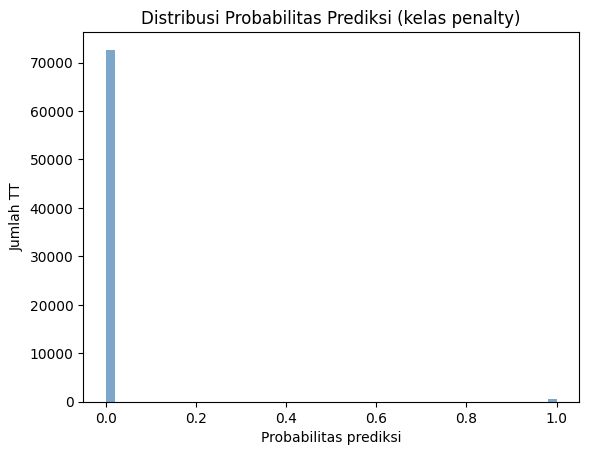

Min: 7.0771726e-08
Max: 0.99999857


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_proba, bins=50, color='steelblue', alpha=0.7)
plt.title("Distribusi Probabilitas Prediksi (kelas penalty)")
plt.xlabel("Probabilitas prediksi")
plt.ylabel("Jumlah TT")
plt.show()

print("Min:", np.min(y_proba))
print("Max:", np.max(y_proba))

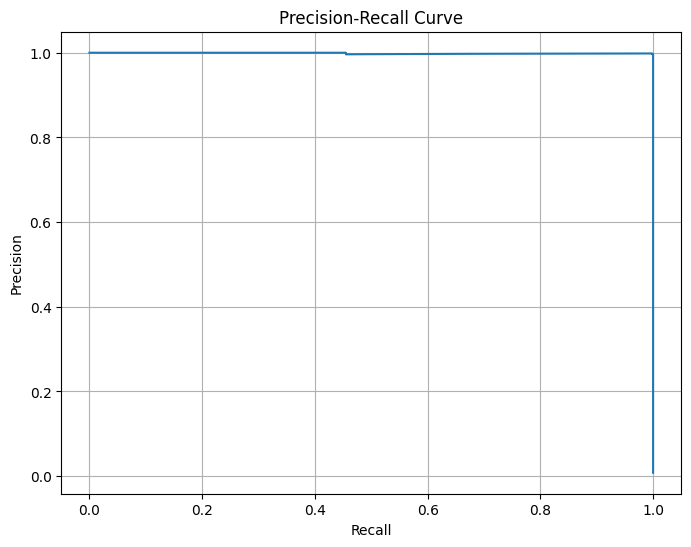

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

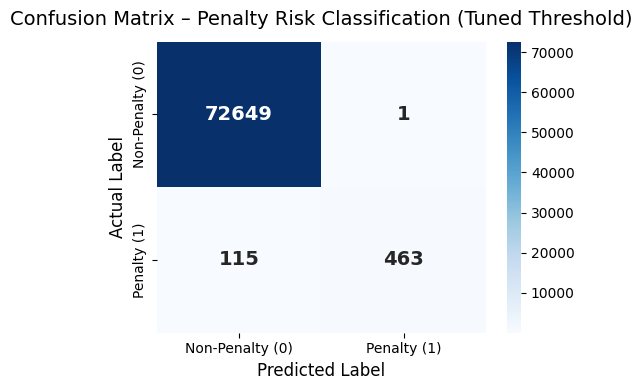

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# pilih hasil mana yang mau ditampilkan
y_true = y_test
y_pred_show = y_pred_adj   # hasil tuned threshold (0.985)

cm = confusion_matrix(y_true, y_pred_show)
labels = ['Non-Penalty (0)', 'Penalty (1)']

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels,
    annot_kws={'size':14, 'weight':'bold'}
)

plt.title('Confusion Matrix – Penalty Risk Classification (Tuned Threshold)', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.tight_layout()
plt.show()

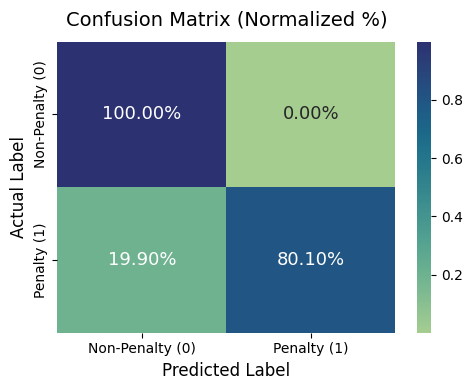

In [ ]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4))
sns.heatmap(
    cmn, annot=True, fmt='.2%', cmap='crest',
    xticklabels=labels, yticklabels=labels,
    annot_kws={'size':13}
)
plt.title('Confusion Matrix (Normalized %)', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.tight_layout()
plt.show()

Prediksi Nilai Penaltynya

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor


# Pastikan target numeric & bersih
df['PotensiPenalty_num'] = pd.to_numeric(df['PotensiPenalty'], errors='coerce')
df_reg = df[(df['IsPenalty'] == 1) & (df['PotensiPenalty_num'] > 0)].copy()

# Jika dataset regresi terlalu kecil, beri warning ringan
print(f"[INFO] Sampel untuk regresi penalty: {len(df_reg)} baris.")

# Fitur sama seperti klasifikasi (aman karena reuse preprocessor)
reg_X = df_reg[[c for c in feature_cols if c in df_reg.columns]].copy()
reg_y = df_reg['PotensiPenalty_num'].astype(float)

# Split
Xtr, Xva, ytr, yva = train_test_split(
    reg_X, reg_y, test_size=0.2, random_state=42
)

# Model regresi + log-transform target (stabilkan outlier)
reg_base = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1
)

reg_pipe = Pipeline(steps=[
    ('prep', preprocess),  # reuse encoder & imputer dari klasifikasi
    ('reg', TransformedTargetRegressor(
        regressor=reg_base,
        func=np.log1p,      # y' = log(1+y)
        inverse_func=np.expm1
    ))
])

# Train
reg_pipe.fit(Xtr, ytr)

yhat_va = reg_pipe.predict(Xva)
yhat_va = np.clip(yhat_va, 0, None)

MAE  = mean_absolute_error(yva, yhat_va)
MSE  = mean_squared_error(yva, yhat_va)   # tanpa squared=
RMSE = np.sqrt(MSE)                       # RMSE manual
MAPE = (np.abs((yva - yhat_va) / np.maximum(yva, 1e-9))).mean() * 100.0
R2   = r2_score(yva, yhat_va)

print("=== Validation Metrics (Penalty Amount) ===")
print({
    "n_train": int(len(Xtr)),
    "n_valid": int(len(Xva)),
    "MAE_Rp": float(round(MAE, 2)),
    "RMSE_Rp": float(round(RMSE, 2)),
    "MAPE_percent": float(round(MAPE, 2)),
    "R2": float(round(R2, 4)),
})


[INFO] Sampel untuk regresi penalty: 2891 baris.
=== Validation Metrics (Penalty Amount) ===
{'n_train': 2312, 'n_valid': 579, 'MAE_Rp': 1432728.35, 'RMSE_Rp': 5406401.36, 'MAPE_percent': 57.95, 'R2': 0.1878}


In [ ]:
val_idx = Xva.index
err = (yva - yhat_va).abs()
probe = df.loc[val_idx, ['Severity','Customers','Region Name','Vendor Name']].copy()
probe['AbsError'] = err
print(probe.groupby('Severity')['AbsError'].mean().sort_values(ascending=False).head(10))
print(probe.groupby('Customers')['AbsError'].mean().sort_values(ascending=False).head(10))

Severity
MAJOR        282815.724330
EMERGENCY    193385.881459
Name: AbsError, dtype: float64
Customers
H3I          445951.475000
TSEL         279121.466102
XL           232162.047490
ISAT         124461.296875
SMARTFREN    112301.415753
Name: AbsError, dtype: float64
